# Deep Learning
----------
## Assignment 5

The goal of this assignment is to train a Word2Vec skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

-----------

### Word2vec: Overview

   Image 1                                |  Image 2
:----------------------------------------:|:------------------------------------------:
![Image 1](images/5_word2vec_blocks.png)  | ![Image 2](images/5_word2vec_details.png)
Word2vec                                  |  Comparing Embeddings


The input word ('CAT') will be vectorized into a random embedding at first. Then, thanks to a simple linear model we will be able to learn the correct representation or embedding of our word given the context. 
Nevertheless, It would be computationaly expensive to compute the error for all the words in the vocabulary. Therefore, we use a sampled softmax (Image 1).

The cosine distance is used as a comparison metric between embeddings because the lenghts of the vectors are irelevant to classification. In fact, this is why we often prefer embeddings with unit norm (Image 2).

During the learning phase, the optimizer will optimize the softmax_weights **AND** the embeddings.
This is because the embeddings are defined as a variable quantity and the
optimizer's `minimize` method will by default modify all variable quantities 
that contribute to the tensor it is passed.
See docs on `tf.train.Optimizer.minimize()` for more details.

----------

In [22]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab, pyplot as plt
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

plt.style.use('ggplot')

### Download the data from the source website if necessary.

In [23]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
    """Download a file if not present, and make sure it's the right size."""
    if not os.path.exists(filename):
        filename, _ = urlretrieve(url + filename, filename)
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified %s' % filename)
    else:
        print(statinfo.st_size)
        raise Exception(
          'Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


### Read the data into a string.

In [24]:
def read_data(filename):
    """Extract the first file enclosed in a zip file as a list of words"""
    with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data
  
words = read_data(filename)
print('Data size %d words' % len(words))

Data size 17005207 words


In [25]:
print("Sample of the data: {}".format(words[:10]))

Sample of the data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


### Build the dictionary and replace rare words with UNK token.

In [5]:
vocabulary_size = 50000

def build_dataset(words):
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count = unk_count + 1
        data.append(index)
    count[0][1] = unk_count
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
    return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156]


### Function to generate a training batch for the skip-gram model.

In [6]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [ skip_window ]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['anarchism', 'as', 'a', 'originated', 'as', 'term', 'a', 'of']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['anarchism', 'term', 'originated', 'a', 'as', 'of', 'term', 'originated']


![batchgen1](images/5_word2vec_batchgen1.png)

    skip_window : How many words to consider left and right.
    num_skips : How many times to reuse an input to generate a label.

The skip window must be defined such as:
* ```batch_size % num_skips == 0```
* ```num_skips <= 2 * skip_window```

### Train a skip-gram model

In [7]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

    # Input data.
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    # Variables.
    # Initialize random embedings Uniform([-1, 1])
    embeddings = tf.Variable(
        tf.random_uniform(
            [vocabulary_size, embedding_size], 
            minval=-1.0, 
            maxval=1.0
        )
    )
    
    # Initialize weights
    softmax_weights = tf.Variable(
        tf.truncated_normal(
            [vocabulary_size, embedding_size],
            stddev=1.0 / math.sqrt(embedding_size)
        )
    )
    
    
    # Initialize biases
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
    
    # Model.
    # Look up embeddings for inputs.
    embed = tf.nn.embedding_lookup(embeddings, train_dataset)
    
    # Compute the softmax loss, using a sample of the negative labels each time.
    loss = tf.reduce_mean(
        tf.nn.sampled_softmax_loss(
            weights=softmax_weights, 
            biases=softmax_biases, 
            inputs=embed,
            labels=train_labels, 
            num_sampled=num_sampled,
            num_classes=vocabulary_size
        )
    )

    # Optimizer.
    # Note: The optimizer will optimize the softmax_weights AND the embeddings.
    # This is because the embeddings are defined as a variable quantity and the
    # optimizer's `minimize` method will by default modify all variable quantities 
    # that contribute to the tensor it is passed.
    # See docs on `tf.train.Optimizer.minimize()` for more details.
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
    
    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [14]:
num_steps = 100001
epochs_to_verbose = 10000

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    
    average_loss = 0
    for step in range(num_steps):
        batch_data, batch_labels = generate_batch(
            batch_size, num_skips, skip_window)
        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        
        # Print the average loss estimate over the last epochs_to_verbose batches.
        if step % epochs_to_verbose == 0:
            if step > 0:
                average_loss = average_loss / epochs_to_verbose
                
            print('Average loss at step %d: %f' % (step, average_loss))
            average_loss = 0
            
        # Show the 8 nearest words arround the validation word
        # Note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % epochs_to_verbose == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
                
    final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 7.337689
Nearest to that: partitive, ir, venetia, bobo, retaliate, amused, homilies, everson,
Nearest to most: whitehead, access, laud, displacing, ducktales, profited, cleanup, clarinetists,
Nearest to is: judgements, rejecting, mcmaster, vaz, purging, spader, waltham, unresponsive,
Nearest to system: courtiers, zu, turboprop, abstained, fierce, printing, thy, micah,
Nearest to during: frees, human, accomplishment, lieu, histidine, pickup, colours, essay,
Nearest to are: compass, tinker, shiki, counterattacks, fl, tippit, davidic, seng,
Nearest to and: isomer, making, overturning, ichthyology, picket, encompasses, refutes, irreversible,
Nearest to were: nanyang, desilu, qualcomm, phenotype, notified, psychiatrists, sensitive, groucho,
Nearest to people: schuler, unsound, oates, communaut, calais, boxers, originators, shear,
Nearest to who: newfoundland, assumptions, dominance, cantata, uomo, huge, indomitable, edu,
Nearest to up: traditional, prefac

Average loss at step 70000: 3.355183
Nearest to that: which, however, what, because, when, how, where, lionel,
Nearest to most: more, many, some, whitehead, less, tagore, use, prolific,
Nearest to is: was, has, are, quenched, does, becomes, requires, be,
Nearest to system: systems, courtiers, undercut, network, cong, micah, tetrahedral, process,
Nearest to during: after, in, until, although, when, while, throughout, at,
Nearest to are: were, is, have, be, include, was, although, those,
Nearest to and: or, but, while, although, exhibiting, however, highwayman, including,
Nearest to were: are, have, was, had, include, be, while, including,
Nearest to people: men, children, scientists, those, residents, individuals, women, person,
Nearest to who: he, she, still, they, courbet, also, often, guatemalan,
Nearest to up: out, off, him, down, them, improve, turn, horde,
Nearest to six: four, five, eight, seven, nine, three, two, zero,
Nearest to which: that, this, what, it, also, actually, stil

### t-SNE

In [9]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

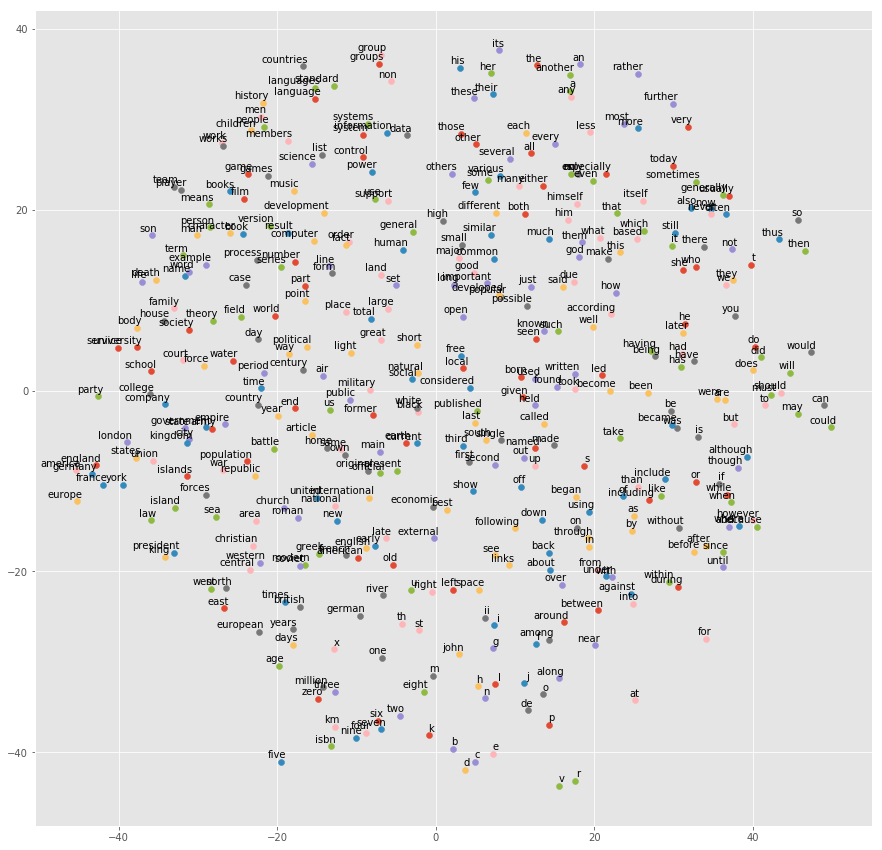

In [10]:
def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15,15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
    pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

---

Problem
-------

An alternative to skip-gram is another Word2Vec model called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---

### CBOW



   Image 4                                     | Parameters
:---------------------------------------------:|:------------------------------------------
![cbow_dims](images/5_word2vec_cbow_dims.png)  | ${x_1, ..., x_c}$: one-hot encoded input context words<br>$C$: window size<br>$V$ vocabulary size<br>$h$: hidden layer<br>$N$: hidden neurons<br>$W$: weight matrix
CBOW Dimensions                                |  

The CBOW architecture predicts the current word based on the context while the Skip-gram predicts surrounding words given the current word.

![cbow_vs_skipgram](images/5_word2vec_cbow_vs_skipgram.png)


### Function to generate a training batch for CBOW model.

As for the skip-gram, the ```skip_window``` is the amount of words we're looking at from each side of a given word. Therefore ```skip_window % 2 == 1```


In [61]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    
    # span: skip_window on both sides plus the target word
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    
    # This time, each bach will contain all the words in the span minus the target word
    batch = np.ndarray(shape=(batch_size, 2 * skip_window), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    
    # Buffer to store the current span
    buffer = collections.deque(maxlen=span)
    
    # Fill the buffer with the first span
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    
    for i in range(batch_size):  # for each batch
        target = skip_window  # target label at the center of the buffer
        
        labels[i, 0] = buffer[target]

        for j in range(num_skips): # size of span
            batch[i, j] = buffer[j] if j < skip_window else buffer[j + 1]        
            
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
        
    return batch, labels


print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    
    for i in range(labels.shape[0]):
        print('    batch: {} ===> label: {}'.format(
            [reverse_dictionary[bi] for bi in batch[i]],
            reverse_dictionary[labels.reshape(8)[i]]
        ))


data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
    batch: ['anarchism', 'as'] ===> label: originated
    batch: ['originated', 'a'] ===> label: as
    batch: ['as', 'term'] ===> label: a
    batch: ['a', 'of'] ===> label: term
    batch: ['term', 'abuse'] ===> label: of
    batch: ['of', 'first'] ===> label: abuse
    batch: ['abuse', 'used'] ===> label: first
    batch: ['first', 'against'] ===> label: used

with num_skips = 4 and skip_window = 2:
    batch: ['anarchism', 'originated', 'a', 'term'] ===> label: as
    batch: ['originated', 'as', 'term', 'of'] ===> label: a
    batch: ['as', 'a', 'of', 'abuse'] ===> label: term
    batch: ['a', 'term', 'abuse', 'first'] ===> label: of
    batch: ['term', 'of', 'first', 'used'] ===> label: abuse
    batch: ['of', 'abuse', 'used', 'against'] ===> label: first
    batch: ['abuse', 'first', 'against', 'early'] ===> label: used
    batch: ['first', 'used', 'early', 'worki